# Section 1. Data Preprocessing & Cleaning

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os 
import sys
import datetime as DT

os.chdir(r'C:\Users\Asus\Documents\Holmusk data\datasciencepositionatholmusk')
bill_amount = pd.read_csv('bill_amount.csv')
bill_id = pd.read_csv('bill_id.csv')
clinical_data = pd.read_csv('clinical_data.csv')
demo = pd.read_csv('demographics.csv')

In [2]:
#convert to lowercase for ease of application
demo.gender = demo.gender.apply(lambda x: x.lower())

In [3]:
demo.race = demo.race.apply(lambda x: x.lower())

In [4]:
demo.resident_status = demo.resident_status.apply(lambda x: x.lower())

In [5]:
#Identifying errant/abnormal inputs for categorical variables within the demographics spreadsheet
demo.gender.value_counts()

female    1396
male      1333
m          170
f          101
Name: gender, dtype: int64

In [6]:
demo.race.value_counts()

chinese    1915
malay       629
indian      195
others      161
india       100
Name: race, dtype: int64

In [7]:
demo.resident_status.value_counts()

singaporean          1782
singapore citizen     610
pr                    465
foreigner             143
Name: resident_status, dtype: int64

In [8]:
#Standardising male & female categorical variables to 'male' and 'female'
demo.gender = demo.gender.apply(lambda x: 'male' if x == 'm' else('female' if x == 'f' else (x)))

In [9]:
#Standardising 'indian' category for race 
demo.race = demo.race.apply(lambda x: 'indian' if x == 'india' else(x))

In [10]:
#Standardising 'singaporean' category for resident status because singapore citizens are singaporeans
demo.resident_status = demo.resident_status.apply(lambda x: 'singaporean' if x == 'singapore citizen' else(x))

In [11]:
demo = demo.set_index('patient_id')

From a visual analysis of the correlation heatmap, none of the variables exhibit potential collinearity except for weight and height. 

In [12]:
clinical_data = clinical_data.sort_values(['id', 'date_of_admission'])

In [13]:
#Removing duplicated patient id samples from the spreadsheet to simplify the analysis 
cd_dup = clinical_data[[not i for i in clinical_data.duplicated(subset = ['id'])]]

In [14]:
#Handling NaN values. From visual data observation, the NaN values were from the medical history variables, which are binary in nature. 
cd_dup = cd_dup.fillna(value = 0)

In [15]:
cd_dup.medical_history_3 = cd_dup.medical_history_3.apply(lambda x: x if type(x) == int else (1 if x == 'Yes' else (0)))

In [16]:
cd_dup.medical_history_2 = cd_dup.medical_history_2.astype('int64')
cd_dup.medical_history_5 = cd_dup.medical_history_5.astype('int64')

Feature engineering for the given dataset. The inpatient duration is potentially more relevant than the dates of admission & discharge themselves. As such, we engineer a new feature, inpatient duration, which would be the difference in days between discharge & admission.

In [17]:
cd_dup.date_of_admission = cd_dup.date_of_admission.astype('datetime64')
cd_dup.date_of_discharge = cd_dup.date_of_discharge.astype('datetime64')

In [18]:
cd_dup['Year'] = cd_dup.date_of_admission.dt.days

AttributeError: 'DatetimeProperties' object has no attribute 'days'

In [19]:
cd_dup['inpatient_D'] = (cd_dup.date_of_discharge - cd_dup.date_of_admission).dt.days

In [20]:
cd_dup['BMI'] = (cd_dup.weight/(cd_dup.height*cd_dup.height) * 10000)

In [21]:
cd_dup['N_Hist'] = cd_dup.medical_history_1 + cd_dup.medical_history_2 + cd_dup.medical_history_3 + cd_dup.medical_history_4 + cd_dup.medical_history_5 + cd_dup.medical_history_6 + cd_dup.medical_history_7  

In [22]:
cd_dup['N_Med'] = cd_dup.preop_medication_1 + cd_dup.preop_medication_2 + cd_dup.preop_medication_3 + cd_dup.preop_medication_4 + cd_dup.preop_medication_5 

In [23]:
cd_dup['N_Symp'] = cd_dup.symptom_1 + cd_dup.symptom_2 + cd_dup.symptom_3 + cd_dup.symptom_4 + cd_dup.symptom_5 

In [24]:
cd_dup = cd_dup.drop(['date_of_discharge', 'weight', 'height'], axis =1)

In [25]:
cd_dup = cd_dup.set_index('id')

In [26]:
joined = cd_dup.merge(demo, left_index = True, right_index = True)

In [27]:
#From the given date of birth, we can calculate their age 
joined.date_of_birth = joined.date_of_birth.astype('datetime64')
joined.date_of_admission = joined.date_of_admission.astype('datetime64')

In [28]:
joined['age'] = joined.date_of_admission.dt.year - joined.date_of_birth.dt.year

In [29]:
joined = joined.drop('date_of_birth', axis =1)

In [30]:
bill_id['patient_id'] = bill_id.patient_id.astype(str)

In [31]:
bill = pd.merge(bill_id, bill_amount, on = 'bill_id')

In [32]:
bill = bill.drop('bill_id', axis =1 )

In [33]:
#Summing up bills from the 4 separate bill_id for each patient_id and date_of_admission
bg = bill.groupby(['patient_id', 'date_of_admission']).amount.sum()

In [34]:
bg_ri = bg.reset_index()

In [35]:
#Simplifying the model by taking only the first admission for each patient _id
bg_first = bg_ri[[not i for i in bg_ri.duplicated(subset = 'patient_id')]]

In [36]:
bg_first = bg_first.set_index('patient_id')

In [65]:
#merge the joined dataset(which merges clinical_data & demographics) and the bg_first dataset(which merges bill_amount & bill_id)
merged = joined.merge(bg_first, left_index = True, right_index = True)

In [66]:
merged["Year"] = merged.date_of_admission_y.astype('datetime64').dt.year

In [67]:
merged = merged.drop(['date_of_admission_x', 'date_of_admission_y'], axis = 1)

In [68]:
#Normalization of numerical columns. Not done on categorical variables for variable inference 
#Choose samples which lie within 3 standard deviations from the mean of normalized variables to preserve sample numbers 
import scipy as sp

numerical_columns = ['amount', 'inpatient_D', 'BMI', 'lab_result_1', 'lab_result_2', 'lab_result_3']
merged_or = merged[(np.abs(sp.stats.zscore(merged[numerical_columns])) < 3).all(axis=1)]

In [69]:
merged_or.describe()

,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,...,lab_result_2,lab_result_3,inpatient_D,BMI,N_Hist,N_Med,N_Symp,age,amount,Year
count,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,...,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000
mean,0.162862,0.287564,0.034753,0.052129,0.058944,0.247359,0.256218,0.500170,0.587734,0.818399,...,27.442624,99.617036,11.081090,28.887756,1.099830,3.246678,3.062351,52.240886,21232.128352,2012.904940
std,0.369303,0.452704,0.183185,0.222326,0.235560,0.431551,0.436618,0.500085,0.492326,0.385581,...,2.452304,15.119199,2.832323,4.070715,0.916365,1.030781,1.073570,14.600365,8826.831861,1.416438
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,20.100000,57.000000,3.000000,17.508651,0.000000,0.000000,0.000000,22.000000,2946.100354,2011.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,25.800000,88.000000,9.000000,26.154824,0.000000,3.000000,2.000000,39.000000,14579.626555,2012.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,27.400000,100.000000,11.000000,28.870523,1.000000,3.000000,3.000000,50.000000,19933.214177,2013.000000
75%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,29.200000,110.000000,13.000000,31.601591,2.000000,4.000000,4.000000,65.000000,26479.242239,2014.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,34.500000,143.000000,19.000000,40.945291,4.000000,5.000000,5.000000,85.000000,52224.523780,2015.000000


C:\Users\Asus\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


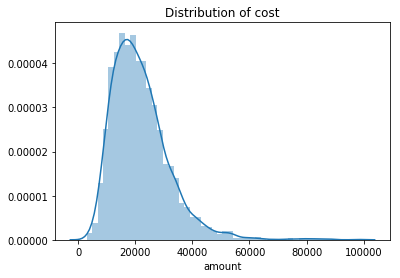

In [70]:
distPlot = sns.distplot(merged['amount'])
plt.title("Distribution of cost")
plt.show()

C:\Users\Asus\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


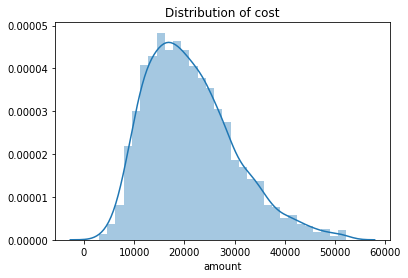

In [71]:
distPlot = sns.distplot(merged_or['amount'])
plt.title("Distribution of cost")
plt.show()

In [41]:
merged.amount.describe()
#NOTE: Handle outlier cases (max) & assess for need to do log transformation

count     3000.000000
mean     21798.335703
std      10161.000119
min       2946.100354
25%      14665.890997
50%      20101.522184
75%      26733.192619
max      98120.870207
Name: amount, dtype: float64

In [72]:
merged_or.amount.describe()
#NOTE: Handle outlier cases (max) & assess for need to do log transformation

count     2935.000000
mean     21232.128352
std       8826.831861
min       2946.100354
25%      14579.626555
50%      19933.214177
75%      26479.242239
max      52224.523780
Name: amount, dtype: float64

C:\Users\Asus\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


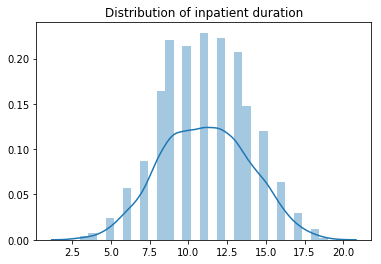

In [73]:
distPlot_inD = sns.distplot(merged_or['inpatient_D'], axlabel = False)
plt.title("Distribution of inpatient duration")
plt.show()

In [74]:
merged_or.inpatient_D.describe()

count    2935.000000
mean       11.081090
std         2.832323
min         3.000000
25%         9.000000
50%        11.000000
75%        13.000000
max        19.000000
Name: inpatient_D, dtype: float64

C:\Users\Asus\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


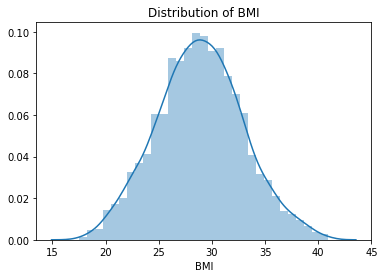

In [75]:
distPlot_bmi = sns.distplot(merged_or['BMI'])
plt.title("Distribution of BMI")
plt.show()

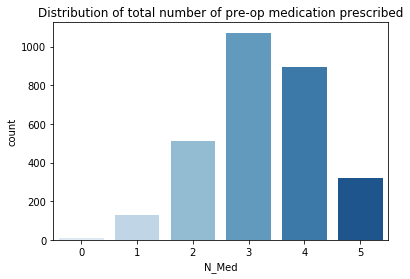

In [76]:
distPlot_N_med = sns.countplot(merged_or['N_Med'], palette = 'Blues')
plt.title("Distribution of total number of pre-op medication prescribed")
plt.show()

From the countplots obtained for all the preop_medications, we can observe that preop_medication_3 and preop_medication_5 are prescribed to patients more frequently than the rest. These two medications could be common medications. 

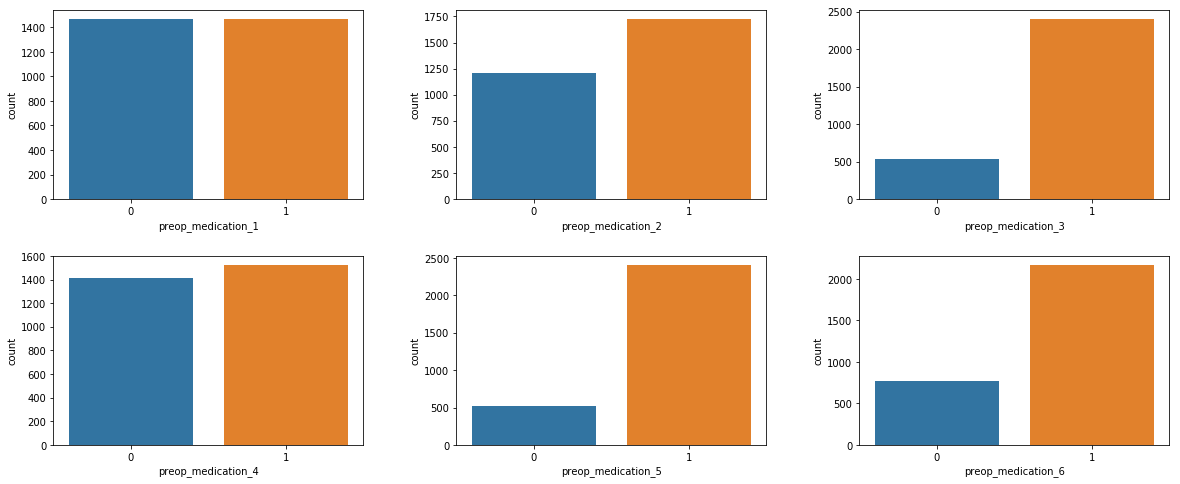

In [77]:
fig, ax = plt.subplots(figsize = (20, 8))

ax1 = plt.subplot2grid((2, 3), (0, 0))
ax2 = plt.subplot2grid((2, 3), (0, 1))
ax3 = plt.subplot2grid((2, 3), (0, 2))
ax4 = plt.subplot2grid((2, 3), (1, 0))
ax5 = plt.subplot2grid((2, 3), (1, 1))
ax6 = plt.subplot2grid((2, 3), (1, 2))

plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

sns.countplot(merged_or["preop_medication_1"],  ax = ax1)
sns.countplot(merged_or["preop_medication_2"],  ax = ax2)
sns.countplot(merged_or["preop_medication_3"],  ax = ax3)
sns.countplot(merged_or["preop_medication_4"],  ax = ax4)
sns.countplot(merged_or["preop_medication_5"],  ax = ax5)
sns.countplot(merged_or["preop_medication_6"],  ax = ax6)

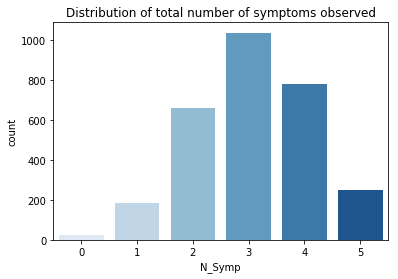

In [82]:
distPlot_N_Symp = sns.countplot(merged_or['N_Symp'], palette = 'Blues')
plt.title("Distribution of total number of symptoms observed")
plt.show()

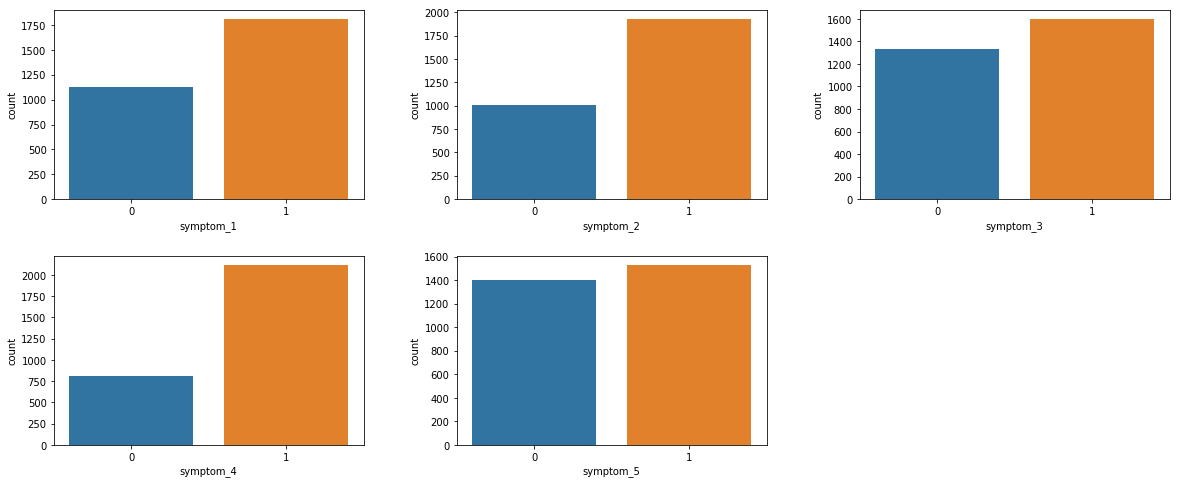

In [83]:
fig, ax = plt.subplots(figsize = (20, 8))

ax1 = plt.subplot2grid((2, 3), (0, 0))
ax2 = plt.subplot2grid((2, 3), (0, 1))
ax3 = plt.subplot2grid((2, 3), (0, 2))
ax4 = plt.subplot2grid((2, 3), (1, 0))
ax5 = plt.subplot2grid((2, 3), (1, 1))

plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

sns.countplot(merged_or["symptom_1"],  ax = ax1)
sns.countplot(merged_or["symptom_2"],  ax = ax2)
sns.countplot(merged_or["symptom_3"],  ax = ax3)
sns.countplot(merged_or["symptom_4"],  ax = ax4)
sns.countplot(merged_or["symptom_5"],  ax = ax5)

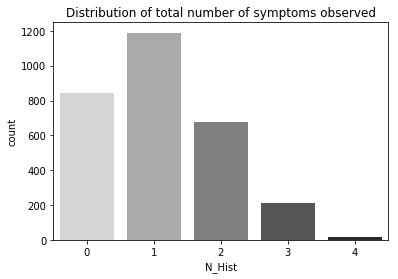

In [85]:
distPlot_N_Hist = sns.countplot(merged_or['N_Hist'], palette = 'Blues')
plt.title("Distribution of total number of symptoms observed")
plt.show()

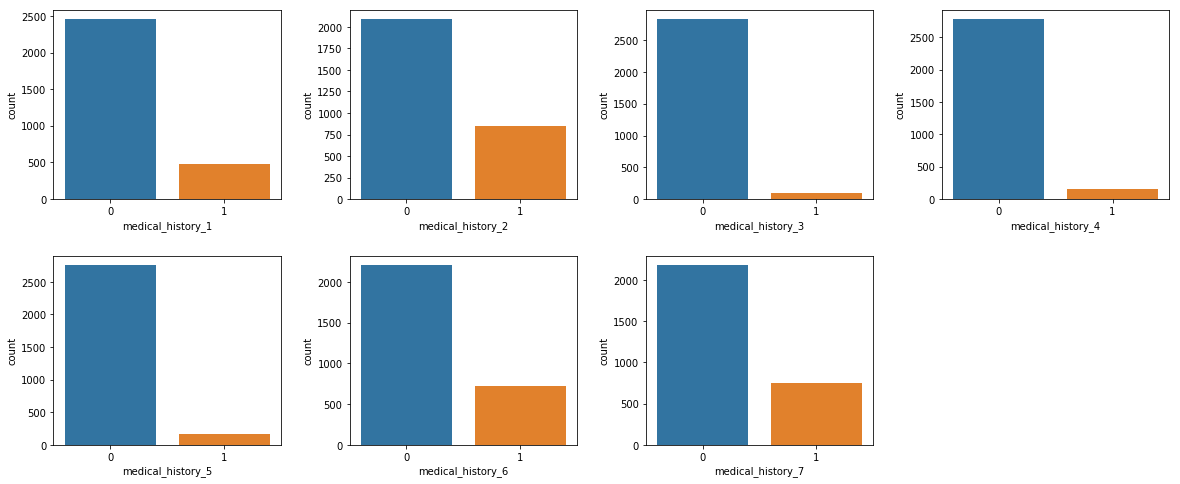

In [86]:
fig, ax = plt.subplots(figsize = (20, 8))

ax1 = plt.subplot2grid((2, 4), (0, 0))
ax2 = plt.subplot2grid((2, 4), (0, 1))
ax3 = plt.subplot2grid((2, 4), (0, 2))
ax4 = plt.subplot2grid((2, 4), (0, 3))
ax5 = plt.subplot2grid((2, 4), (1, 0))
ax6 = plt.subplot2grid((2, 4), (1, 1))
ax7 = plt.subplot2grid((2, 4), (1, 2))

plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

sns.countplot(merged_or["medical_history_1"],  ax = ax1)
sns.countplot(merged_or["medical_history_2"],  ax = ax2)
sns.countplot(merged_or["medical_history_3"],  ax = ax3)
sns.countplot(merged_or["medical_history_4"],  ax = ax4)
sns.countplot(merged_or["medical_history_5"],  ax = ax5)
sns.countplot(merged_or["medical_history_6"],  ax = ax6)
sns.countplot(merged_or["medical_history_7"],  ax = ax7)

In [87]:
merged_or.BMI.describe()

count    2935.000000
mean       28.887756
std         4.070715
min        17.508651
25%        26.154824
50%        28.870523
75%        31.601591
max        40.945291
Name: BMI, dtype: float64

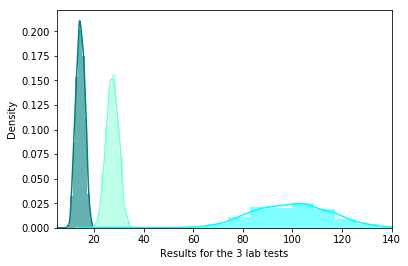

In [122]:
ax = merged_or['lab_result_1'].hist(density=True, stacked=True, color='teal', alpha=0.6)
merged_or['lab_result_1'].plot(kind='density', color='teal')
ax = merged_or['lab_result_2'].hist(density=True, stacked=True, color='aquamarine', alpha=0.5)
merged_or['lab_result_2'].plot(kind='density', color='aquamarine')
ax = merged_or['lab_result_3'].hist(density=True, stacked=True, color='aqua', alpha=0.5)
merged_or['lab_result_3'].plot(kind='density', color='aqua')
ax.set(xlabel='Results for the 3 lab tests')
plt.xlim(5, 140)
plt.show()
#Most likely the 3 tests are different

# Gender vs Cost 

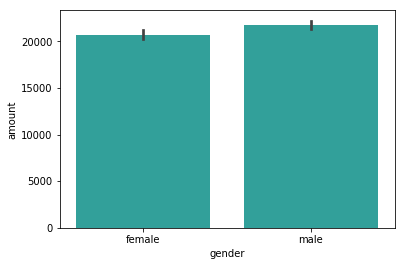

In [119]:
sns.barplot('gender', 'amount', data=merged_or, color="lightseagreen")

# Race vs Cost  

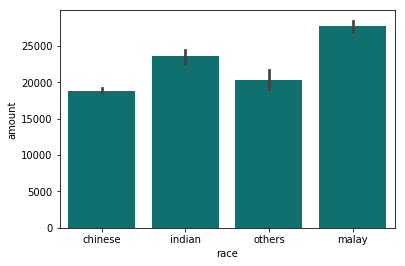

In [90]:
sns.barplot('race', 'amount', data=merged_or, color="teal")


# Resident Status vs Cost

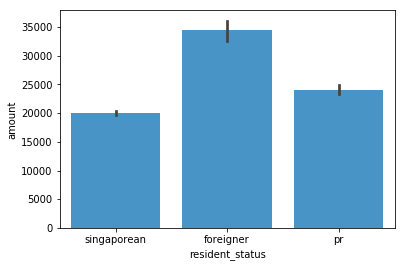

In [91]:
sns.barplot('resident_status', 'amount', data=merged_or, color="#3498db")

# Inpatient Duration vs Cost

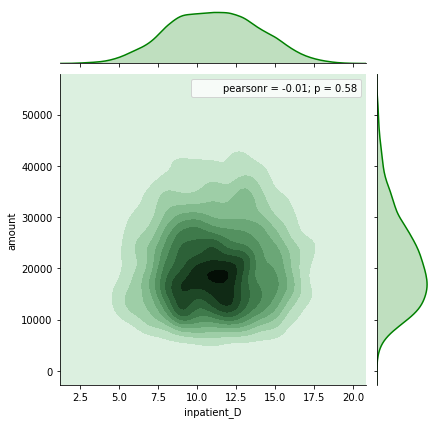

In [92]:
cmap = sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95, as_cmap = True)
sns.jointplot('inpatient_D', 'amount', data=merged_or, kind = 'kde', cmap = cmap, color = 'g')

# BMI vs Cost

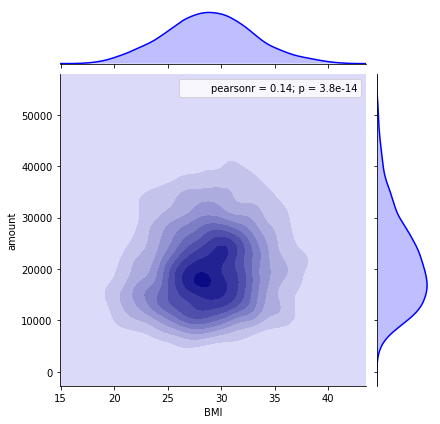

In [125]:
cmap = sns.light_palette("navy", as_cmap = True)
sns.jointplot('BMI', 'amount', data=merged_or, kind = 'kde', cmap = cmap, color="blue")

# Age vs Cost

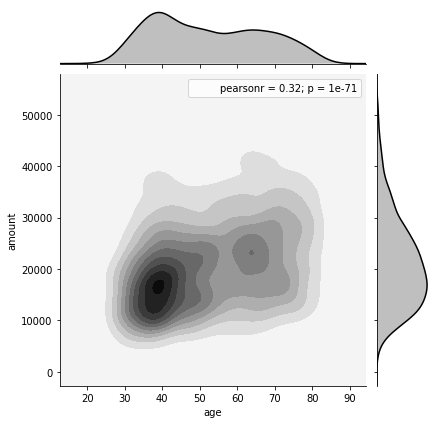

In [94]:
sns.jointplot('age', 'amount', data=merged_or, kind = 'kde', color="k")

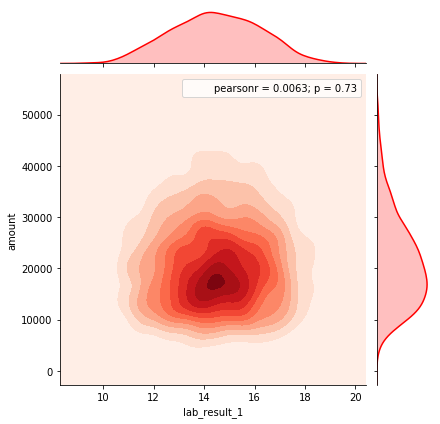

In [198]:
sns.jointplot('lab_result_1', 'amount', data=merged_or, kind = 'kde', cmap="Reds", color = 'r')

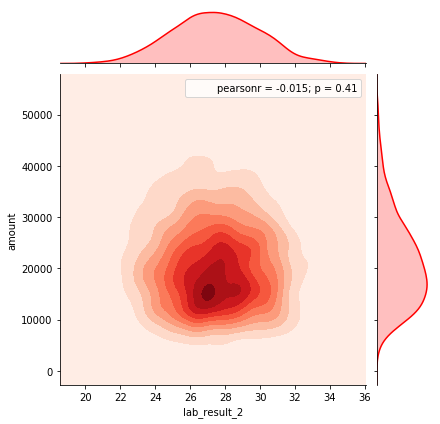

In [211]:
sns.jointplot('lab_result_2', 'amount', data=merged_or, kind = 'kde', cmap="Reds", color = 'r')

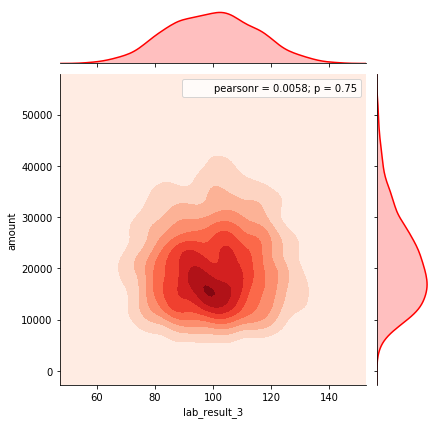

In [212]:
sns.jointplot('lab_result_3', 'amount', data=merged_or, kind = 'kde', cmap="Reds", color = 'r')

# Medical History Availability vs Cost

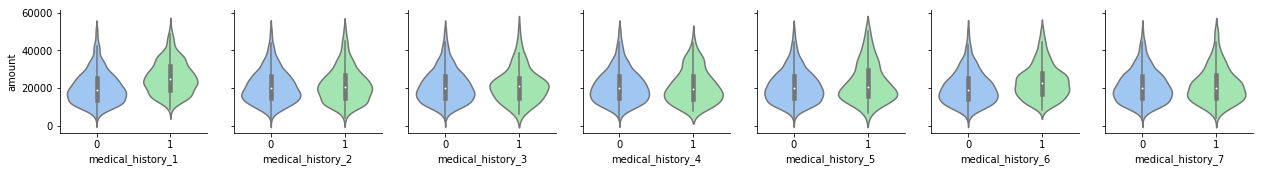

In [95]:
g = sns.PairGrid(x_vars=["medical_history_1", "medical_history_2", "medical_history_3", "medical_history_4", "medical_history_5",
                        "medical_history_6", "medical_history_7"],
                 y_vars=["amount"], data = merged_or)
g.map(sns.violinplot, palette="pastel")

# Symptom presence vs Cost

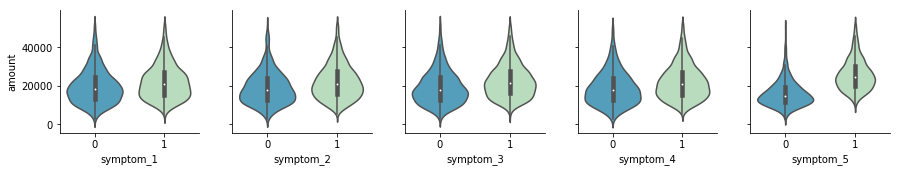

In [111]:
g = sns.PairGrid(x_vars=["symptom_1", "symptom_2", "symptom_3", "symptom_4", "symptom_5"], 
                 y_vars=["amount"], data = merged_or)
g.map(sns.violinplot, palette="GnBu_r")

# Pre-op medication type prescription vs Cost

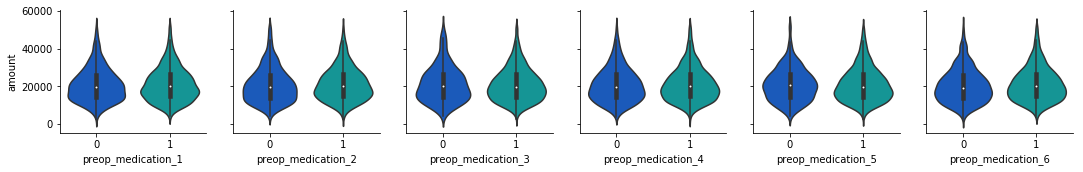

In [118]:
g = sns.PairGrid(x_vars=["preop_medication_1", "preop_medication_2", "preop_medication_3", "preop_medication_4", "preop_medication_5", "preop_medication_6"], 
                 y_vars=["amount"], data = merged_or)
g.map(sns.violinplot, palette="winter")

# Number of pre-op medication prescribed vs cost

Text(0.5,0,'Number of Medication Prescribed')

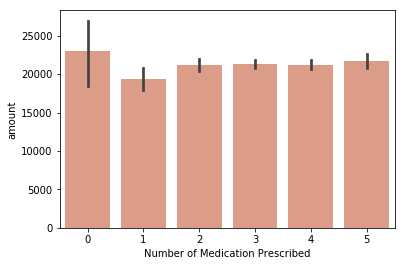

In [184]:
sns.barplot('N_Med', 'amount', data=merged_or, color="darksalmon")
plt.xlabel('Number of Medication Prescribed')

# Total number of symptoms present vs cost 

Text(0.5,0,'Number of Symptoms Present')

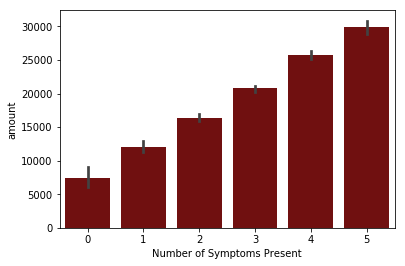

In [97]:
sns.barplot('N_Symp', 'amount', data=merged_normed, color="maroon")
plt.xlabel('Number of Symptoms Present')

# Total number of medical history present vs cost

Text(0.5,0,'Number of Medical History Present')

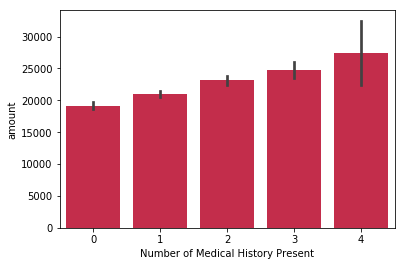

In [96]:
sns.barplot('N_Hist', 'amount', data=merged_normed, color="crimson")
plt.xlabel('Number of Medical History Present')

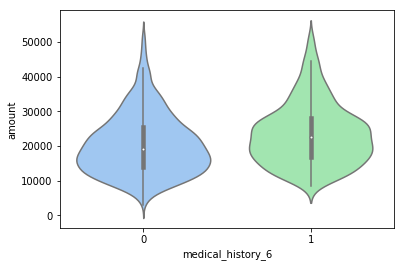

In [102]:
sns.violinplot(x="medical_history_6", y="amount", data=merged_or, palette="pastel")

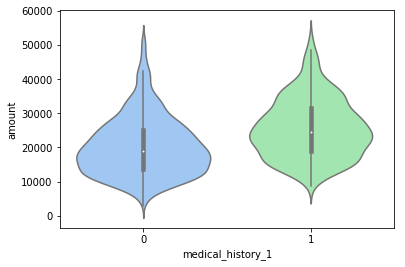

In [103]:
sns.violinplot(x="medical_history_1", y="amount", data=merged_or, palette="pastel")

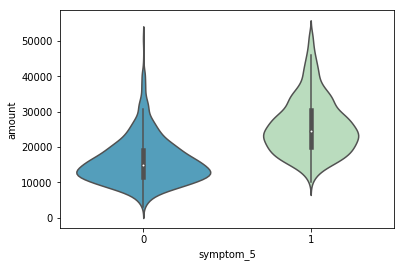

In [127]:
sns.violinplot(x="symptom_5", y="amount", data=merged_or, palette="GnBu_r")

C:\Users\Asus\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


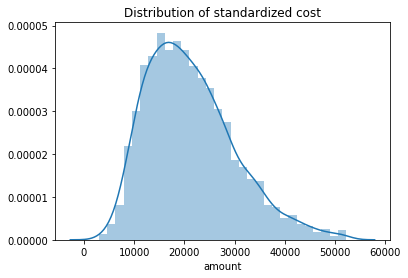

In [83]:
distPlot_cost_normed = sns.distplot(merged_normed['amount'])
plt.title("Distribution of standardized cost")
plt.show()

In [84]:
merged_normed.skew()

medical_history_1     1.827054
medical_history_2     0.939161
medical_history_3     5.083003
medical_history_4     4.031701
medical_history_5     3.747306
medical_history_6     1.171648
medical_history_7     1.117444
preop_medication_1   -0.000682
preop_medication_2   -0.356650
preop_medication_3   -1.652651
preop_medication_4   -0.078465
preop_medication_5   -1.673636
preop_medication_6   -1.091033
symptom_1            -0.481766
symptom_2            -0.661323
symptom_3            -0.180032
symptom_4            -0.993312
symptom_5            -0.085300
lab_result_1         -0.022742
lab_result_2         -0.004279
lab_result_3          0.016645
inpatient_D           0.018023
BMI                   0.079351
N_Hist                0.516904
N_Med                -0.237621
N_Symp               -0.168761
age                   0.250304
amount                0.749955
dtype: float64

In [85]:
merged_normed.kurtosis()

medical_history_1      1.339037
medical_history_2     -1.118739
medical_history_3     23.853174
medical_history_4     14.264335
medical_history_5     12.050516
medical_history_6     -0.627670
medical_history_7     -0.751831
preop_medication_1    -2.001364
preop_medication_2    -1.874078
preop_medication_3     0.731755
preop_medication_4    -1.995203
preop_medication_5     0.801604
preop_medication_6    -0.810200
symptom_1             -1.769107
symptom_2             -1.563718
symptom_3             -1.968931
symptom_4             -1.014022
symptom_5             -1.994083
lab_result_1          -0.489897
lab_result_2          -0.286485
lab_result_3          -0.367245
inpatient_D           -0.419862
BMI                   -0.156512
N_Hist                -0.354818
N_Med                 -0.259810
N_Symp                -0.337746
age                   -1.113312
amount                 0.381825
dtype: float64

# Multivariate Analysis: Year-on-Year Cost Analysis 
One factor to consider for the cost of care is the general increase in cost of care each year. Hence, we conduct an analysis on the indicator categorical variables, medical_history, preop_medication and symptom.

For example, if the price of preop_medication_1 increases each year, we would expect an increasing trend to be observed for patients who were prescribed preop_medication_1 as the year goes by. For symptoms and medical_history, this could mean that the prices of drugs/treatments associated with the symptom or medical history to increase with each year. 

In [106]:
merged2 = joined.merge(bg_first, left_index = True, right_index = True).drop('date_of_admission_x', axis = 1)
merged2["Year"] = merged2.date_of_admission_y.astype('datetime64').dt.year

In [107]:
merged.Year.value_counts()

2011    670
2012    609
2013    602
2014    573
2015    546
Name: Year, dtype: int64

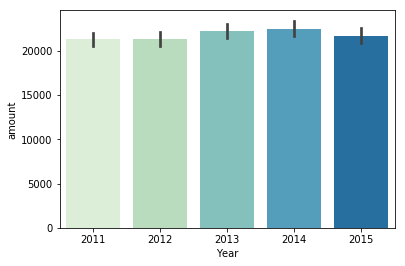

In [108]:
sns.barplot(x="Year", y="amount", data=merged, palette="GnBu")

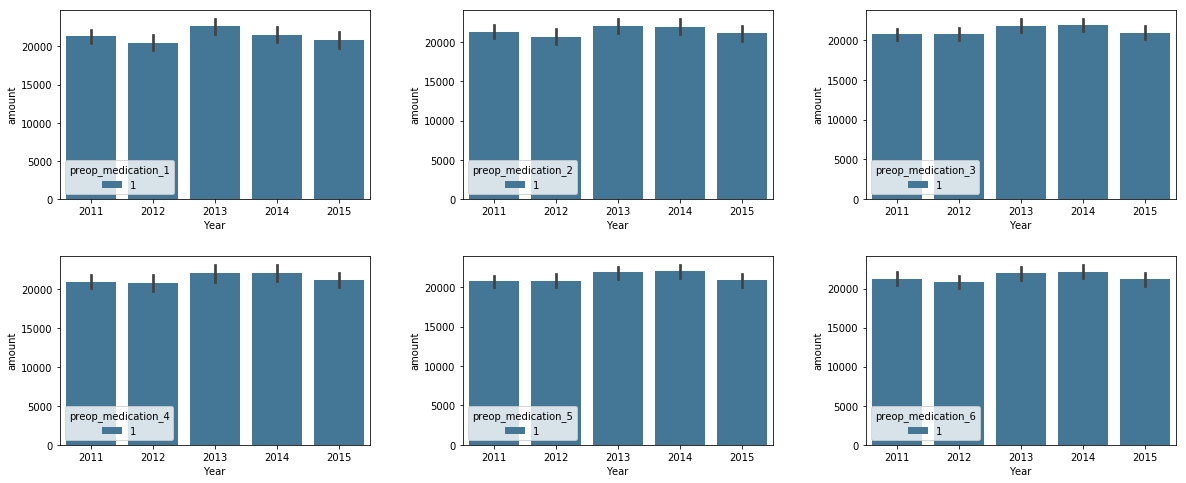

In [143]:
fig, ax = plt.subplots(figsize = (20, 8))

ax1 = plt.subplot2grid((2, 3), (0, 0))
ax2 = plt.subplot2grid((2, 3), (0, 1))
ax3 = plt.subplot2grid((2, 3), (0, 2))
ax4 = plt.subplot2grid((2, 3), (1, 0))
ax5 = plt.subplot2grid((2, 3), (1, 1))
ax6 = plt.subplot2grid((2, 3), (1, 2))

plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

sns.barplot(x="Year", y="amount", hue="preop_medication_1", data=merged_or[merged_or.preop_medication_1 == 1], palette="mako", ax = ax1)
sns.barplot(x="Year", y="amount", hue="preop_medication_2", data=merged_or[merged_or.preop_medication_2 == 1], palette="mako", ax = ax2)
sns.barplot(x="Year", y="amount", hue="preop_medication_3", data=merged_or[merged_or.preop_medication_3 == 1], palette="mako", ax = ax3)
sns.barplot(x="Year", y="amount", hue="preop_medication_4", data=merged_or[merged_or.preop_medication_4 == 1], palette="mako", ax = ax4)
sns.barplot(x="Year", y="amount", hue="preop_medication_5", data=merged_or[merged_or.preop_medication_5 == 1], palette="mako", ax = ax5)
sns.barplot(x="Year", y="amount", hue="preop_medication_6", data=merged_or[merged_or.preop_medication_6 == 1], palette="mako", ax = ax6)

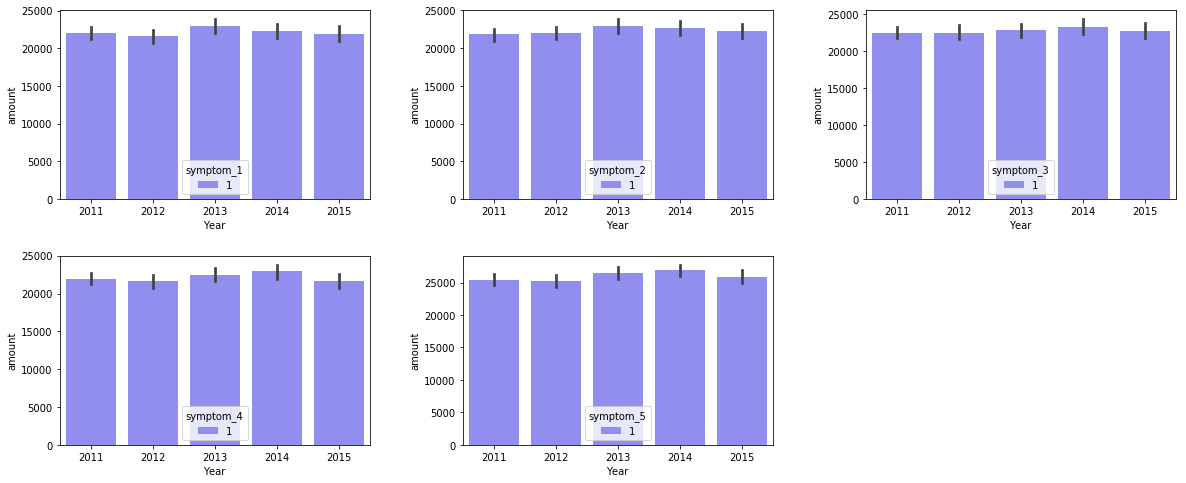

In [140]:
fig, ax = plt.subplots(figsize = (20, 8))

ax1 = plt.subplot2grid((2, 3), (0, 0))
ax2 = plt.subplot2grid((2, 3), (0, 1))
ax3 = plt.subplot2grid((2, 3), (0, 2))
ax4 = plt.subplot2grid((2, 3), (1, 0))
ax5 = plt.subplot2grid((2, 3), (1, 1))

plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

sns.barplot(x="Year", y="amount", hue="symptom_1", data=merged_or[merged_or.symptom_1 == 1], palette="cool", ax = ax1)
sns.barplot(x="Year", y="amount", hue="symptom_2", data=merged_or[merged_or.symptom_2 == 1], palette="cool", ax = ax2)
sns.barplot(x="Year", y="amount", hue="symptom_3", data=merged_or[merged_or.symptom_3 == 1], palette="cool", ax = ax3)
sns.barplot(x="Year", y="amount", hue="symptom_4", data=merged_or[merged_or.symptom_4 == 1], palette="cool", ax = ax4)
sns.barplot(x="Year", y="amount", hue="symptom_5", data=merged_or[merged_or.symptom_5 == 1], palette="cool", ax = ax5)

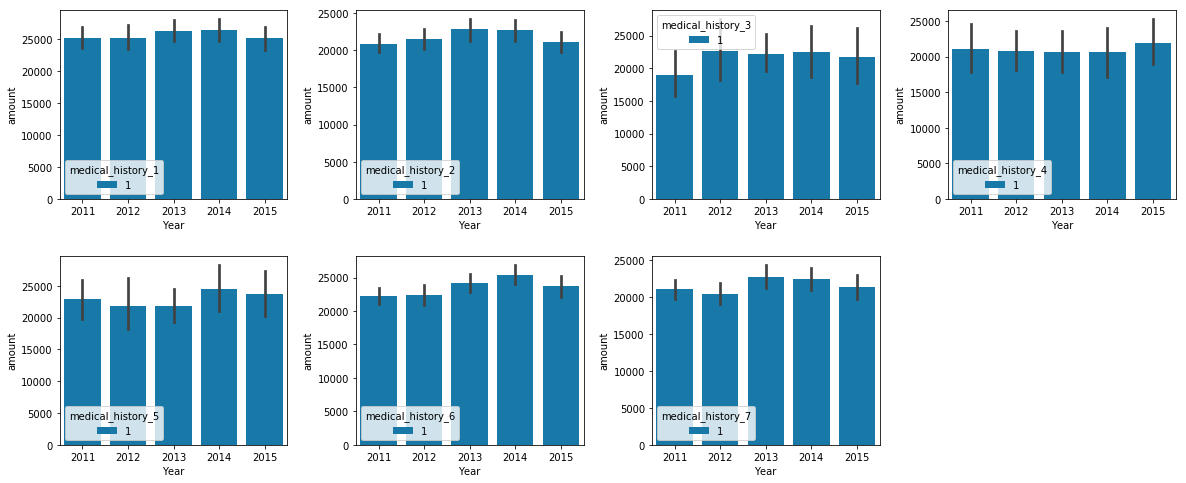

In [144]:
fig, ax = plt.subplots(figsize = (20, 8))

ax1 = plt.subplot2grid((2, 4), (0, 0))
ax2 = plt.subplot2grid((2, 4), (0, 1))
ax3 = plt.subplot2grid((2, 4), (0, 2))
ax4 = plt.subplot2grid((2, 4), (0, 3))
ax5 = plt.subplot2grid((2, 4), (1, 0))
ax6 = plt.subplot2grid((2, 4), (1, 1))
ax7 = plt.subplot2grid((2, 4), (1, 2))

plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

sns.barplot(x="Year", y="amount", hue="medical_history_1", data=merged_or[merged_or.medical_history_1 == 1], palette="winter", ax = ax1)
sns.barplot(x="Year", y="amount", hue="medical_history_2", data=merged_or[merged_or.medical_history_2 == 1], palette="winter", ax = ax2)
sns.barplot(x="Year", y="amount", hue="medical_history_3", data=merged_or[merged_or.medical_history_3 == 1], palette="winter", ax = ax3)
sns.barplot(x="Year", y="amount", hue="medical_history_4", data=merged_or[merged_or.medical_history_4 == 1], palette="winter", ax = ax4)
sns.barplot(x="Year", y="amount", hue="medical_history_5", data=merged_or[merged_or.medical_history_5 == 1], palette="winter", ax = ax5)
sns.barplot(x="Year", y="amount", hue="medical_history_6", data=merged_or[merged_or.medical_history_6 == 1], palette="winter", ax = ax6)
sns.barplot(x="Year", y="amount", hue="medical_history_7", data=merged_or[merged_or.medical_history_7 == 1], palette="winter", ax = ax7)

In [147]:
Data = merged.reset_index().drop('index', axis =1)

In [148]:
to_encode = ['gender', 'race', 'resident_status', 'Year']
Data_encoded = pd.get_dummies(Data, columns = to_encode)

# Checking for correlation and potential multicollinearity 

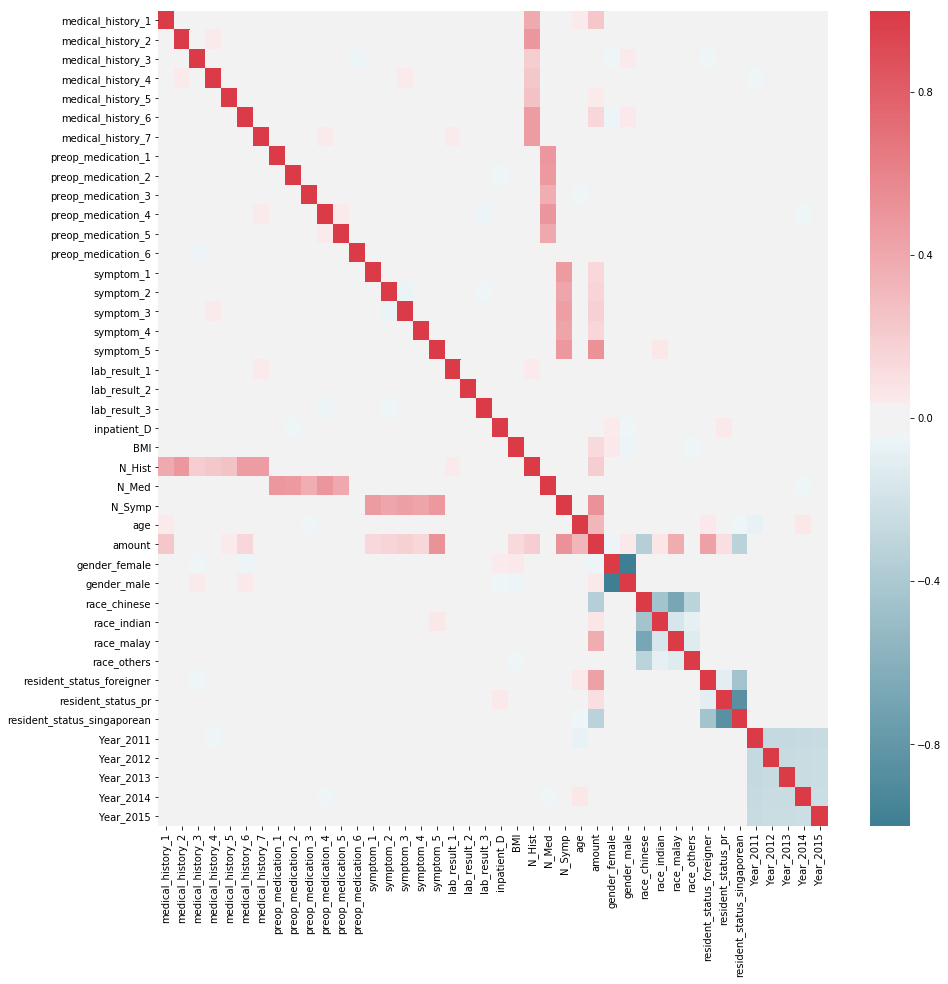

In [149]:
f, ax = plt.subplots(figsize=(15, 15))
corr = Data_encoded.corr()
sns.heatmap(corr,mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), ax = ax)

In [150]:
numer_list = ['inpatient_D', 'BMI', 'N_Hist', 'N_Symp', 'age', 'lab_result_1', 'lab_result_2', 'lab_result_3']

for key in numer_list: 
    col_mean = np.mean(Data_encoded[key])
    col_stdev = np.std(Data_encoded[key])
    Data_encoded[key] = Data_encoded[key].apply(lambda x: ((x - col_mean)/col_stdev))

# Random Forest Model Training

In [151]:
X = Data_encoded.drop('amount', axis =1)
X_ = X.as_matrix()
Y = Data_encoded.loc[:, 'amount'].astype('int64')

C:\Users\Asus\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [152]:
X_headers = list(X)

In [153]:
from sklearn.cross_validation import ShuffleSplit
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.metrics import r2_score
from collections import defaultdict

scores = defaultdict(list)
et_rgr = ExtraTreesRegressor()

for train_idx, test_idx in ShuffleSplit(len(X), 100, .3):
    X_train, X_test = X_[train_idx], X_[test_idx]
    Y_train, Y_test = Y[train_idx], Y[test_idx]
    et_rgr = et_rgr.fit(X_train, Y_train)
    acc = r2_score(Y_test, et_rgr.predict(X_test))
    for i in range(X.shape[1]):
        X_t = X_test.copy()
        np.random.shuffle(X_t[:, i])
        shuff_acc = r2_score(Y_test, et_rgr.predict(X_t))
        scores[X_headers[i]].append((acc-shuff_acc)/acc)

C:\Users\Asus\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [171]:
feature_score = sorted([(round(np.mean(score), 4), feat) for feat, score in scores.items()], reverse=True)
fi = dict(feature_score)
stdev = [(np.std(score), feat) for feat, score in scores.items()]


# Print the feature ranking
print("Feature ranking:")

for f in range(X_.shape[1]):
    print("%d. %s (%f)" % (f + 1, feature_score[f][1] , feature_score[f][0]))

Feature ranking:
1. symptom_5 (0.422000)
2. resident_status_foreigner (0.410900)
3. race_malay (0.354300)
4. age (0.170600)
5. N_Symp (0.168900)
6. medical_history_1 (0.091800)
7. medical_history_6 (0.037300)
8. race_chinese (0.020400)
9. resident_status_singaporean (0.012700)
10. race_indian (0.011900)
11. resident_status_pr (0.011200)
12. symptom_3 (0.011100)
13. BMI (0.010100)
14. N_Hist (0.003500)
15. symptom_2 (0.002900)
16. symptom_4 (0.002100)
17. preop_medication_5 (0.000800)
18. medical_history_7 (0.000300)
19. medical_history_5 (0.000300)
20. lab_result_2 (0.000200)
21. Year_2012 (0.000200)
22. race_others (0.000100)
23. preop_medication_6 (0.000100)
24. gender_male (0.000100)
25. Year_2014 (0.000100)
26. medical_history_4 (-0.000000)
27. medical_history_3 (0.000000)
28. medical_history_2 (-0.000000)
29. symptom_1 (-0.000100)
30. preop_medication_3 (-0.000100)
31. gender_female (-0.000100)
32. lab_result_3 (-0.000200)
33. Year_2013 (-0.000200)
34. Year_2011 (-0.000200)
35. N_

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

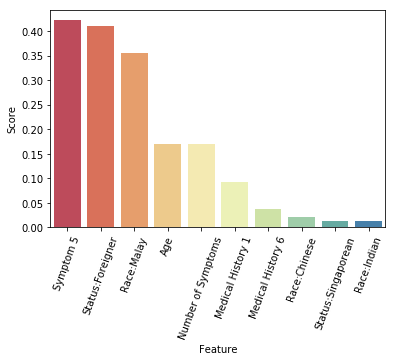

In [183]:
# Plot the feature importances of the forest
df = pd.DataFrame.from_records(list(feature_score), columns = ['Score', 'Feature'])
df.Feature = ['Symptom 5', 'Status:Foreigner', 'Race:Malay', 'Age',
       'Number of Symptoms', 'Medical History 1', 'Medical History 6', 'Race:Chinese',
       'Status:Singaporean', 'Race:Indian', 'Status:PR',
       'Symptom 3', 'BMI', 'N_Hist', 'Symptom 2', 'Symptom 4',
       'Preop Med 5', 'Medical History 7', 'Medical History 5',
       'Lab Result 2', 'Year:2012', 'Race:Others', 'Preop Med 6',
       'Male', 'Year:2014', 'Medical History 4',
       'Medical History 3', 'Medical History 2', 'Symptom 1',
       'Preop Med 3', 'Female', 'Lab Result 3', 'Year:2013',
       'Year_2011', 'Number of Meds', 'Preop Med 4', 'Lab Result 1',
       'Inpatient Duration', 'Preop Med 2', 'Year:2015',
       'Preop Med 1']
sns.barplot(x = 'Feature', y ='Score', data = df.iloc[:10,:], palette = 'Spectral')
plt.xticks(rotation = 70)

In [91]:
from sklearn.feature_selection import RFE

rfe = RFE(estimator= ExtraTreesRegressor(), n_features_to_select =5, step=1)
rfe.fit(X_, np.asarray(Y))

c = list(zip(list(rfe.ranking_), X_headers))
pd.DataFrame.from_records(c).sort_values(by = [0]).head()

,0,1
17,1,symptom_5
33,1,resident_status_foreigner
31,1,race_malay
26,1,age
25,1,N_Symp


In [125]:
to_drop = ["preop_medication_1", "preop_medication_2", "preop_medication_3", "preop_medication_4", "preop_medication_5",
          "medical_history_2", "medical_history_3", "medical_history_4", "medical_history_5", "medical_history_7",]
Data_encoded_2 = Data_encoded.drop(to_drop, axis = 1)

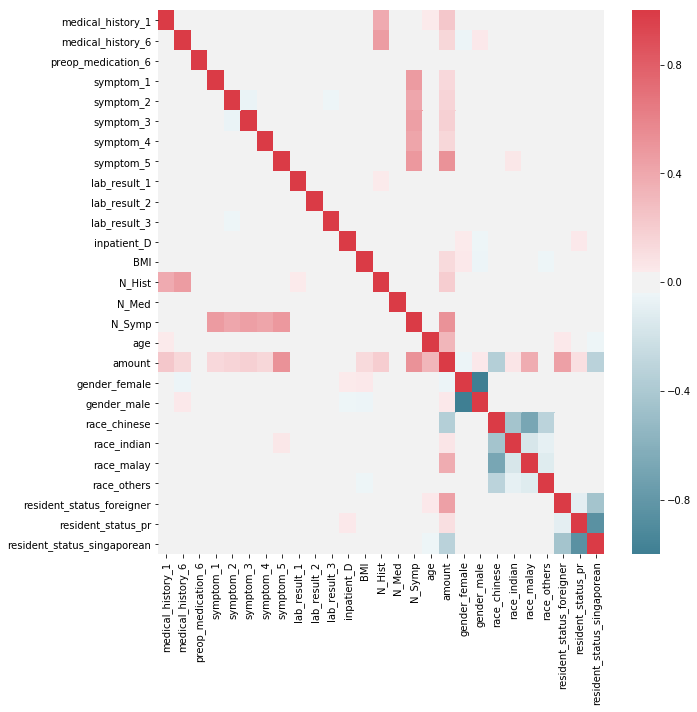

In [126]:
f, ax = plt.subplots(figsize=(10, 10))
corr_2 = Data_encoded_2.corr()
sns.heatmap(corr_2, mask=np.zeros_like(corr_2, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), ax = ax)

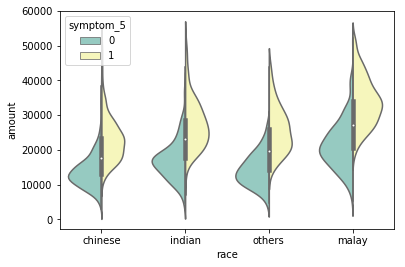

In [213]:
sns.violinplot(x="race", y="amount", hue="symptom_5", data=merged_or,
               split=True, palette="Set3");